# Megaline Phone Company; Smart or Ultra?, by Deborah Thomas

<H2>In this project, I will develop a model, that will analyze Megaline's phone subscribers' behavior,
and use Machine Learning to recommend one of Megaline's newer plans: Smart or Ultra.</H2>

<h2 style="color:red;">Import libraries:</h2>

In [51]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import plotly.express as px


<h2 style="color:red;">Read-in data:</h2>

In [53]:
try:
    mega = pd.read_csv('/datasets/users_behavior.csv')  # Attempt to read from the server path
except FileNotFoundError:
    mega = pd.read_csv('../datasets/users_behavior.csv')  # Fallback to the local path


display(mega.head(20))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<h2 style="color:red;">Quick look at the data:</h2>

In [55]:
mega.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Averages, for each column:
- The average number of calls, per month, per customer, is 63 calls.
- The average call minutes, per month, per customer, is 438 minutes. This is approximately 15 minutes per day.
- The average number of text messages, per month, per customer, is 38 text messages.
- The average number of megabytes used, per month, per customer, is 17,207, or 17.2 GB.
- The majority of people have the Smart plan, not Ultra.

In [57]:
mega.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### There is no missing data.

<h2 style="color:red;">Clean the data:</h2>

### Change column names

In [61]:
mega.rename(columns={'minutes': 'min', 'messages': 'msg'}, inplace=True)

In [62]:
mega.columns

Index(['calls', 'min', 'msg', 'mb_used', 'is_ultra'], dtype='object')

### Change data types

In [64]:
mega['calls'] = mega['calls'].astype(int)
mega['msg'] = mega['msg'].astype(int)

mega['is_ultra'] = mega['is_ultra'].astype(bool)

### Explanation of Data Cleaning:
<b>Column Naming are now shorter</b>
- 'minutes' has been renamed to 'min'
- 'messages' has been renamed to 'msg'

<b>Data Types:</b>
- 'calls' should not be float, because there is no such thing as half a phone call. Changing datatype to int.
- 'msg' should also not be float, because there is no such thing as half a text message. Changing 'msg' datatype to int, also.
- 'is_ultra' has only 1 or 0, so this datatype was changed to type Boolean.

In [66]:
mega.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   min       3214 non-null   float64
 2   msg       3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   bool   
dtypes: bool(1), float64(2), int64(2)
memory usage: 103.7 KB


#### Data is clean now.

<h2 style="color:red;">Analyze the data:</h2>

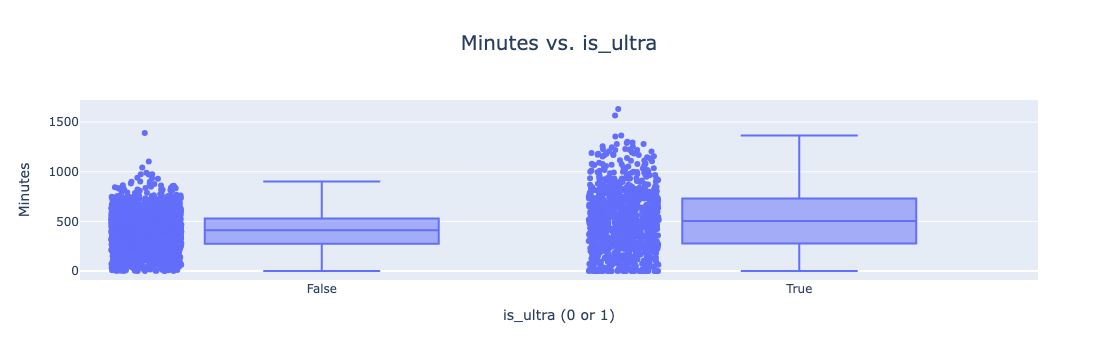

In [69]:
fig_box = px.box(mega, x='is_ultra', y='min', 
                 title='Minutes vs. is_ultra', 
                 labels={'min': 'Minutes', 'is_ultra': 'is_ultra (0 or 1)'},
                 points='all')  # 'all' to show all points along with box plot

# Update the layout to center the title and make it larger
fig_box.update_layout(
    title={
        'text': "Minutes vs. is_ultra",
        'y':0.9,  # Position the title slightly above the center, adjust as necessary
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20  # Adjust to the desired font size
        }
    },
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['False', 'True']  # Optional: better x-axis readability
    )
)

fig_box.show()

### People who use lots of call minutes tend to already be on the 'Ultra' plan. 

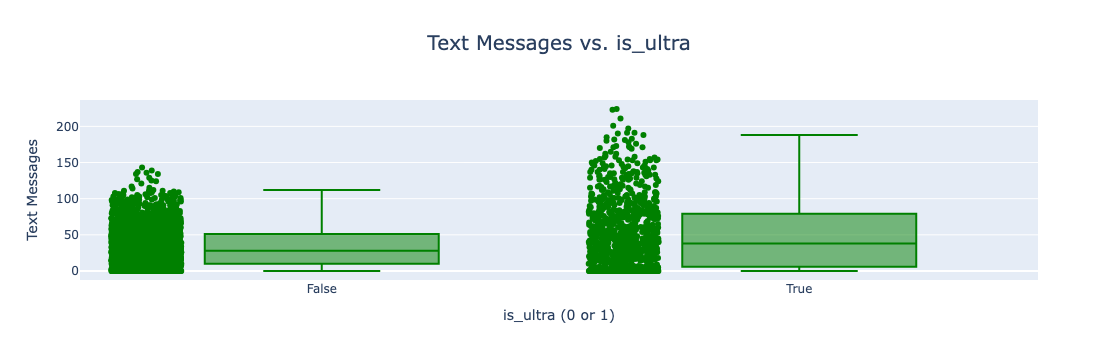

In [71]:
fig_box = px.box(mega, x='is_ultra', y='msg', 
                 title='Messages vs. is_ultra', 
                 labels={'msg': 'Text Messages', 'is_ultra': 'is_ultra (0 or 1)'},
                 points='all')  # 'all' to show all points along with box plot
# Update the layout to center the title and make it larger
fig_box.update_layout(
    title={
        'text': "Text Messages vs. is_ultra",
        'y':0.9,  # Position the title slightly above the center, adjust as necessary
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20  # Adjust to the desired font size
        }
    },
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['False', 'True']  # Optional: better x-axis readability
    )
)
# Update traces to make the bars green
fig_box.update_traces(marker_color='green')
fig_box.show()

### People who use text messaging more, tend to already be on the 'Ultra' plan. 

<h2 style="color:red;">Supervised Learning:</h2>

## Split the data into  train, valid, test. Ratios: 60 / 20 / 20.

In [75]:
# Initial split: 60% training, 40% temp (to later be split into validation and test sets)
mega_train, mega_temp = train_test_split(mega, test_size=0.4, random_state=13)

In [76]:
# Further split the temp dataset into validation and test: 50% validation, 50% test
mega_valid, mega_test = train_test_split(mega_temp, test_size=0.5, random_state=13)

#### I now have these 3 datasets:
- 60% mega_train - The training set is used to build the model.
- 20% mega_valid - The validation set is used to evaluate the model during the training process.
- 20% mega_test - The test set is used to evaluate the performance of the model once it has been trained and validated.

## Create features and target variable for the 3 datasets:

In [79]:
# training / validation / test
features_train = mega_train.drop('is_ultra', axis=1)
target_train = mega_train['is_ultra']

features_valid = mega_valid.drop('is_ultra', axis=1)
target_valid = mega_valid['is_ultra']

features_test = mega_test.drop('is_ultra', axis=1)
target_test = mega_test['is_ultra']

<h2 style="color:red;">Machine Learning Models:</h2>

- <h2 style="color:red;">Decision Tree</h2>

In [82]:
#Create an instance of the class
model = DecisionTreeClassifier(max_depth=5, random_state=12345)

## Train the decision tree model

In [84]:
#Initiate training
model.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=5, random_state=12345)

## Test the decision tree model, for accuracy.

In [86]:
# Validate the model on the validation set. Predict the answers.
predictions_valid = model.predict(features_valid)

# Does it correctly guess it?
validation_accuracy = accuracy_score(target_valid, predictions_valid)
print(f"Validation set accuracy: {validation_accuracy:.2f}")

Validation set accuracy: 0.79


In [87]:
# Evaluate the final model on the test set
predictions_test = model.predict(features_test)
test_accuracy = accuracy_score(target_test, predictions_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

Test set accuracy: 0.79


## Looking at Decision Tree Model at different max_depth :

In [106]:
best_validation_accuracy = 0
best_depth = None
best_model = None

In [108]:
for depth in range(1,6):
    model = DecisionTreeClassifier(random_state=54321, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    
    print("Max_Depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_depth = depth
        best_model = model

Max_Depth = 1 : 0.7356143079315708
Max_Depth = 2 : 0.7651632970451011
Max_Depth = 3 : 0.7916018662519441
Max_Depth = 4 : 0.7900466562986003
Max_Depth = 5 : 0.7869362363919129


#### Max_depth 3 was the best fit. Max_depth 4 was a very close 2nd.

## Evaluate the best model on the test set

In [112]:
# Evaluate the best model on the test set
predictions_test = best_model.predict(features_test)
test_accuracy = accuracy_score(target_test, predictions_test)
print(f"Best Model: Max_Depth = {best_depth}, Validation set accuracy = {best_validation_accuracy:.2f}")
print(f"Test set accuracy = {test_accuracy:.2f}")


Best Model: Max_Depth = 1, Validation set accuracy = 0.79
Test set accuracy = 0.73


- <h2 style="color:red;">Random Forest</h2>

In [46]:
#Create an instance of the class
modelForest = RandomForestClassifier(random_state=12345, n_estimators=3)

## Train the random forest model

In [48]:
modelForest.fit(features_train, target_train)

RandomForestClassifier(n_estimators=3, random_state=12345)

## Test the random forest model, for accuracy

In [50]:
model.score(features_valid, target_valid)

0.7869362363919129

## Looking at the random forest model for best n_estimators

In [52]:
best_score = 0
best_est = 0

for est in range(1, 11):
    modelForest = RandomForestClassifier(random_state=54321, n_estimators=est)
    modelForest.fit(features_train, target_train)
    score = modelForest.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

Accuracy of the best model on the validation set (n_estimators = 10): 0.7776049766718507


#### The best n_estimators, for this random forest is 10.

- <h2 style="color:red;">Logistic Regression</h2>

In [55]:
#Create an instance of the class
modelLog = LogisticRegression(
    random_state=54321, solver="liblinear"
)

## Train the logistic regression model

In [57]:
modelLog.fit(features_train, target_train)

LogisticRegression(random_state=54321, solver='liblinear')

## Test the logistic regression model, for accuracy

In [59]:
score_train = modelLog.score(features_train, target_train)
score_valid = modelLog.score(features_valid, target_valid)

In [60]:
print(
    "Accuracy of the logistic regression model on the training set:",
    score_train,
)
print(
    "Accuracy of the logistic regression model on the validation set:",
    score_valid,
)

Accuracy of the logistic regression model on the training set: 0.703838174273859
Accuracy of the logistic regression model on the validation set: 0.6905132192846034


<h2 style="color:red;">Conclusion:</h2>

## Usage of Megaline customers:
- The average number of calls, per month, per customer, is 63 calls.
- The average call minutes, per month, per customer, is 438 minutes. This is approximately 15 minutes per day.
- The average number of text messages, per month, per customer, is 38 text messages.
- The average number of megabytes used, per month, per customer, is 17,207, or 17.2 GB.
- The majority of people have the Smart plan, not Ultra.
## Supervised Learning Models:
### Decision Tree
- Max_depth 3 was the best fit. Max_depth 4 was a very close 2nd.
- At max_depth 3, the calculations were fast.
- Validation and Test datasets both score 0.791, which means that the model had a 79.1% rate of guessing the correct boolean answer.
### Random Forest
- The best n_estimators for this model was 10. This means that there were 10 trees in this forest. Each of the trees got a vote. The trees' vote was aggregated, and the average was taken, and this average became the final score.
- The accuracy of this model was 0.777. This means that this model had a 77.7% rate of guessing the correct boolean answer.
### Logistic Regression
- The training dataset scored 0.754, which means that this type of model had a 75.4% rate of guessing the correct boolean answer.
## Which model is best for this dataset?
- Decision Tree was the best at guessing the correct target answer, at 79.1% of the time. 